# Estimating the uncertainties in the exoplanet masses

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/scikit-learn-contrib/MAPIE/blob/master/notebooks/regression/exoplanets.ipynb)


In this notebook, we quantify the uncertainty in exoplanet masses predicted by several machine learning models, based on the exoplanet properties. To this aim, we use the exoplanet dataset downloaded from the [NASA Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/) and estimate the prediction intervals using the methods implemented in MAPIE.

In [ ]:
install_mapie = True
if install_mapie:
    !pip install mapie

In [ ]:
from typing_extensions import TypedDict
from typing import Union
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    PolynomialFeatures,
    RobustScaler
)
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from mapie.metrics.regression import regression_coverage_score
from mapie_v1.regression import CrossConformalRegressor, JackknifeAfterBootstrapRegressor
from mapie.subsample import Subsample

warnings.filterwarnings("ignore")

## 1. Data Loading

Let's start by loading the `exoplanets` dataset and looking at the main information.

In [3]:
url_file = "https://raw.githubusercontent.com/scikit-learn-contrib/MAPIE/master/notebooks/regression/exoplanets_mass.csv"
exo_df = pd.read_csv(url_file, index_col=0)

In [4]:
exo_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2746 entries, 1 to 2746
Data columns (total 22 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Discovery_Method                          2746 non-null   object 
 1   Discovery_Year                            2746 non-null   int64  
 2   Solution_type                             2746 non-null   object 
 3   Planet_Orbital_Period_[day]               2284 non-null   float64
 4   Planet_Orbital_SemiMajorAxis_[day]        2017 non-null   float64
 5   Planet_Radius_[Earth_radius]              2168 non-null   float64
 6   Planet_Mass_[Earth_mass]                  2746 non-null   float64
 7   Planet_Mass_Provenance                    2746 non-null   object 
 8   Planet_Eccentricity                       1601 non-null   float64
 9   Planet_Eq_Temperature_[K]                 1056 non-null   float64
 10  Stellar_Effective_Temperature_[K]   

The dataset contains 21 features giving complementary information about the properties of the discovered planet, the star around which the planet revolves, together with the type of discovery method. 7 features are categorical, and 14 are continuous.

Some properties show high variance among exoplanets and stars due to the astronomical nature of such systems. We therefore decide to use a log transformation for the following features to approach a normal distribution.

In [5]:
exo_df["Stellar_Mass_[Solar_mass]"] = exo_df["Stellar_Mass_[Solar_mass]"].replace(0, np.nan)
vars2log = [
    "Planet_Orbital_Period_[day]",
    "Planet_Orbital_SemiMajorAxis_[day]",
    "Planet_Radius_[Earth_radius]",
    "Planet_Mass_[Earth_mass]",
    "Stellar_Radius_[Solar_radius]",
    "Stellar_Mass_[Solar_mass]",
    "Stellar_Effective_Temperature_[K]"
]
for var in vars2log:
    exo_df[var+"_log"] = np.log(exo_df[var])

In [6]:
vars2keep = list(set(exo_df.columns) - set(vars2log))
exo_df = exo_df[vars2keep]

In [7]:
exo_df.head()

,System_V_Magnitude,Solution_type,System_Ks_Magnitude,Number_Stars,Stellar_Radius_[Solar_radius]_log,Planet_Eccentricity,Planet_Mass_Provenance,Discovery_Method,System_Gaia_Magnitude,Planet_Mass_[Earth_mass]_log,...,Stellar_Metallicity_Radio,Planet_Orbital_SemiMajorAxis_[day]_log,Planet_Eq_Temperature_[K],Stellar_Surface_Gravity_[log10(cm/s**2)],Planet_Orbital_Period_[day]_log,Planet_Radius_[Earth_radius]_log,Stellar_Effective_Temperature_[K]_log,Stellar_Mass_[Solar_mass]_log,Number_Planets,System_Distance_[pc]
1,12.618,Published Confirmed,8.916,1,NaN,NaN,Mass,Imaging,12.0572,8.294050,...,NaN,5.799093,1700.0,NaN,NaN,NaN,8.308938,-0.162519,1,139.135
2,12.618,Published Confirmed,8.916,1,NaN,NaN,Mass,Imaging,12.0572,8.006368,...,NaN,5.799093,1700.0,NaN,NaN,NaN,8.308938,-0.162519,1,139.135
3,12.618,Published Confirmed,8.916,1,0.270027,NaN,Mass,Imaging,12.0572,8.006368,...,NaN,5.799093,1800.0,4.0,NaN,NaN,8.292298,-0.478036,1,139.135
4,12.618,Published Confirmed,8.916,1,0.300105,NaN,Mass,Imaging,12.0572,7.841100,...,NaN,5.799093,1800.0,NaN,NaN,2.925685,8.308938,-0.162519,1,139.135
5,16.186,Published Confirmed,10.386,1,-0.174353,NaN,Mass,Imaging,14.3374,7.147806,...,[Fe/H],4.770685,1450.0,4.5,NaN,NaN,8.039157,-1.771957,1,128.484


Throughout this tutorial, the target variable will be `Planet_Mass_[Earth_mass]_log`.

In [8]:
target = "Planet_Mass_[Earth_mass]_log"

In [9]:
num_cols = list(exo_df.columns[exo_df.dtypes == "float64"])
cat_cols = list(exo_df.columns[exo_df.dtypes != "float64"])
exo_df[cat_cols] = exo_df[cat_cols].astype(str)

In [10]:
planet_cols = [col for col in num_cols if "Planet_" in col]
star_cols = [col for col in num_cols if "Stellar_" in col]
system_cols = [col for col in num_cols if "System_" in col]

## 2. Data visualization

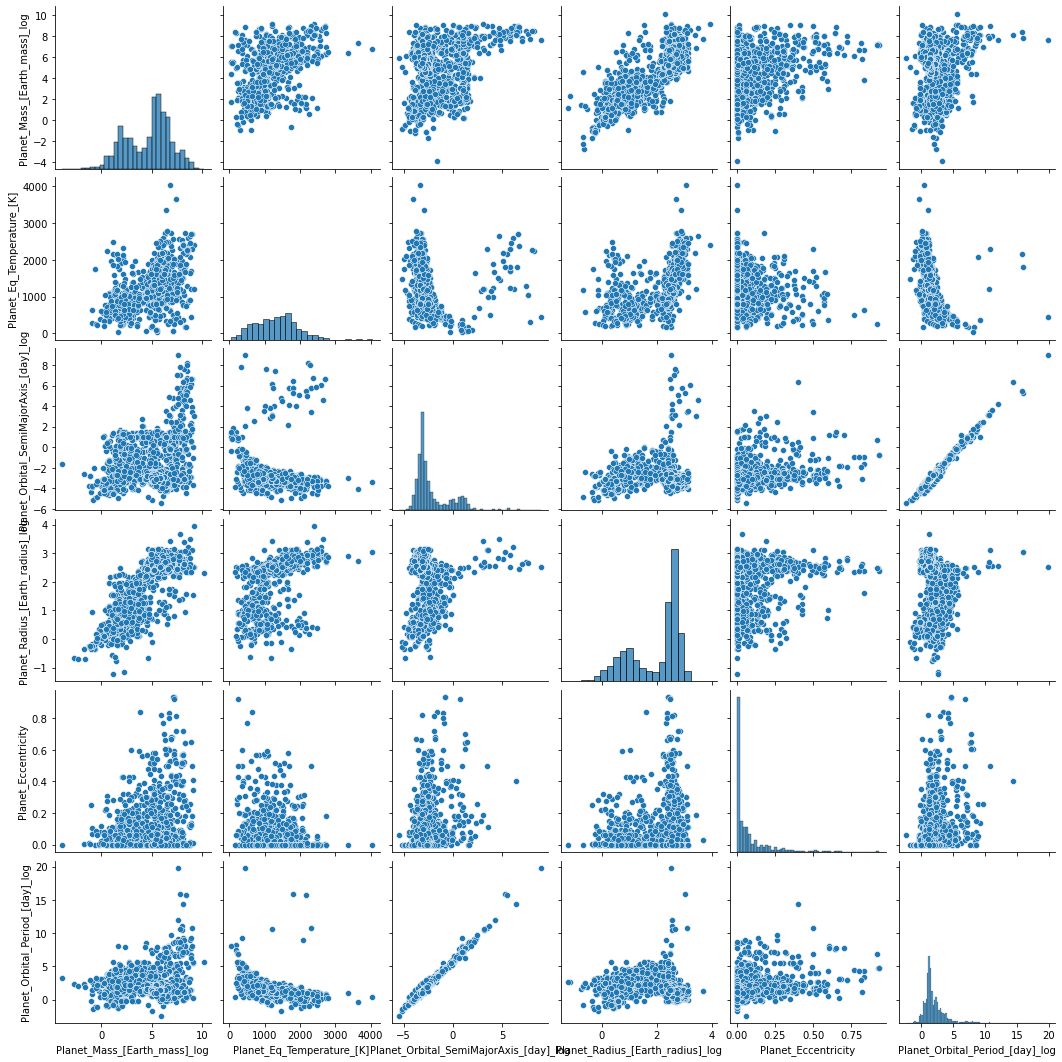

In [ ]:
sns.pairplot(exo_df[planet_cols])

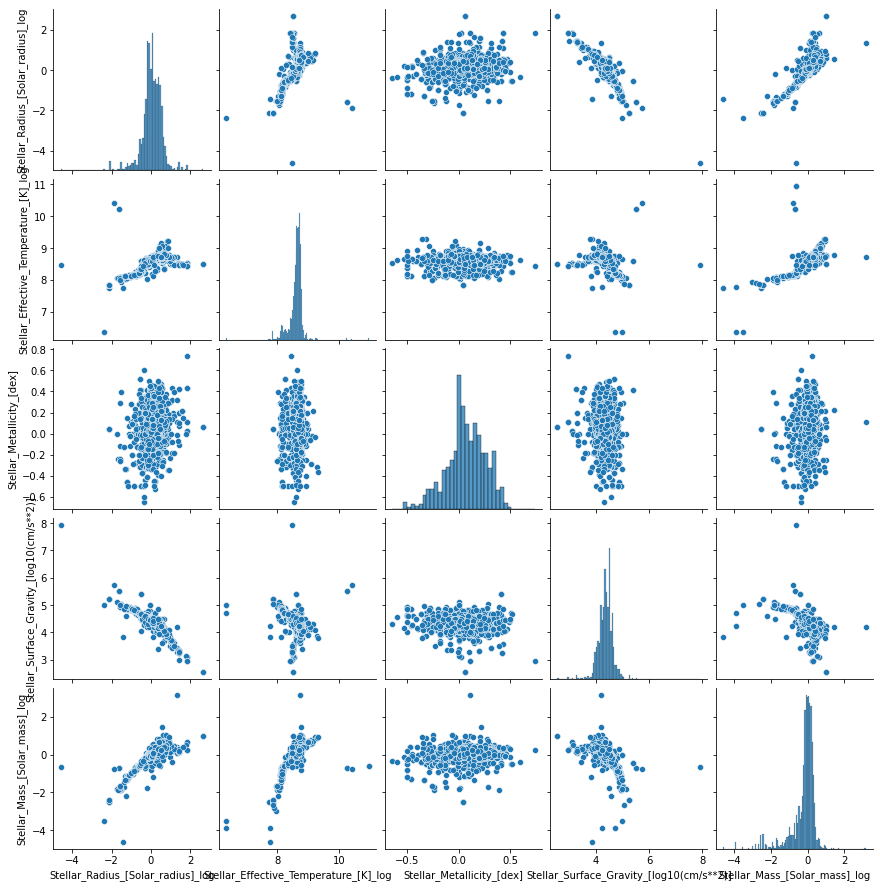

In [ ]:
sns.pairplot(exo_df[star_cols])

## 3. Data preprocessing

In this section, we perform a simple preprocessing of the dataset in order to impute the missing values and encode the categorical features.

In [11]:
endos = list(set(exo_df.columns) - set([target]))
X = exo_df[endos]
y = exo_df[target]

In [12]:
num_cols = list(X.columns[X.dtypes == "float64"])
cat_cols = list(X.columns[X.dtypes != "float64"])
X[cat_cols] = X[cat_cols].astype(str)

In [14]:
imputer_num = SimpleImputer(strategy="mean")
scaler_num = RobustScaler()
imputer_cat = SimpleImputer(strategy="constant", fill_value=-1)
encoder_cat = OneHotEncoder(
    categories="auto",
    drop=None,
    handle_unknown="ignore",
)

In [15]:
numerical_transformer = Pipeline(
    steps=[("imputer", imputer_num), ("scaler", scaler_num)]
)
categorical_transformer = Pipeline(
    steps=[("ordinal", OrdinalEncoder()), ("imputer", imputer_cat), ("encoder", encoder_cat)]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("numerical", numerical_transformer, num_cols),
        ("categorical", categorical_transformer, cat_cols)
    ],
    remainder="drop",
    sparse_threshold=0,
)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

In [17]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

## 4. First estimation of the uncertainties with MAPIE

### Uncertainty estimation

Here, we build our first prediction intervals with MAPIE. To this aim, we adopt the CV+ strategy with 5 folders, using `method="plus"` and `cv=KFold(n_splits=5, shuffle=True)` as input arguments.

In [18]:
def get_regressor(name):
    if name == "linear":
        mdl = LinearRegression()
    elif name == "polynomial":
        degree_polyn = 2
        mdl = Pipeline(
            [
                ("poly", PolynomialFeatures(degree=degree_polyn)),
                ("linear", LinearRegression())
            ]
        )
    elif name == "random_forest":
        mdl = RandomForestRegressor()
    return mdl

In [19]:
mdl = get_regressor("random_forest")

In [21]:
confidence_level = np.arange(0.05, 1, 0.05)
mapie = CrossConformalRegressor(
    estimator=mdl,
    confidence_level=confidence_level,
    method="plus",
    cv=5)

In [22]:
mapie.fit_conformalize(X_train, y_train)

We build prediction intervals for a range of alpha values between 0 and 1.

In [23]:
y_train_pred, y_train_pis = mapie.predict_interval(X_train)
y_test_pred, y_test_pis = mapie.predict_interval(X_test)

### Visualization

The following function offers to visualize the error bars estimated by MAPIE for the selected method and the given confidence level.

In [24]:
def plot_predictionintervals(
    y_train,
    y_train_pred,
    y_train_pred_low,
    y_train_pred_high,
    y_test,
    y_test_pred,
    y_test_pred_low,
    y_test_pred_high,
    suptitle: str,
) -> None:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    
    ax1.errorbar(
        x=y_train,
        y=y_train_pred,
        yerr=(y_train_pred - y_train_pred_low, y_train_pred_high - y_train_pred),
        alpha=0.8,
        label="train",
        fmt=".",
    )
    ax1.errorbar(
        x=y_test,
        y=y_test_pred,
        yerr=(y_test_pred - y_test_pred_low, y_test_pred_high - y_test_pred),
        alpha=0.8,
        label="test",
        fmt=".",
    )
    ax1.plot(
        [y_train.min(), y_train.max()],
        [y_train.min(), y_train.max()],
        color="gray",
        alpha=0.5,
    )
    ax1.set_xlabel("True values", fontsize=12)
    ax1.set_ylabel("Predicted values", fontsize=12)
    ax1.legend()
    
    ax2.scatter(
        x=y_train, y=y_train_pred_high - y_train_pred_low, alpha=0.8, label="train", marker="."
    )
    ax2.scatter(x=y_test, y=y_test_pred_high - y_test_pred_low, alpha=0.8, label="test", marker=".")
    ax2.set_xlabel("True values", fontsize=12)
    ax2.set_ylabel("Interval width", fontsize=12)
    ax2.set_xscale("linear")
    ax2.set_ylim([0, np.max(y_test_pred_high - y_test_pred_low)*1.1])
    ax2.legend()
    std_all = np.concatenate([
        y_train_pred_high - y_train_pred_low, y_test_pred_high - y_test_pred_low
    ])
    type_all = np.array(["train"] * len(y_train) + ["test"] * len(y_test))
    x_all = np.arange(len(std_all))
    order_all = np.argsort(std_all)
    std_order = std_all[order_all]
    type_order = type_all[order_all]
    ax3.scatter(
        x=x_all[type_order == "train"],
        y=std_order[type_order == "train"],
        alpha=0.8,
        label="train",
        marker=".",
    )
    ax3.scatter(
        x=x_all[type_order == "test"],
        y=std_order[type_order == "test"],
        alpha=0.8,
        label="test",
        marker=".",
    )
    ax3.set_xlabel("Order", fontsize=12)
    ax3.set_ylabel("Interval width", fontsize=12)
    ax3.legend()
    ax1.set_title("True vs predicted values")
    ax2.set_title("Prediction interval width vs true values")
    ax3.set_title("Ordered prediction interval width")
    plt.suptitle(suptitle, size=20)
    plt.show()


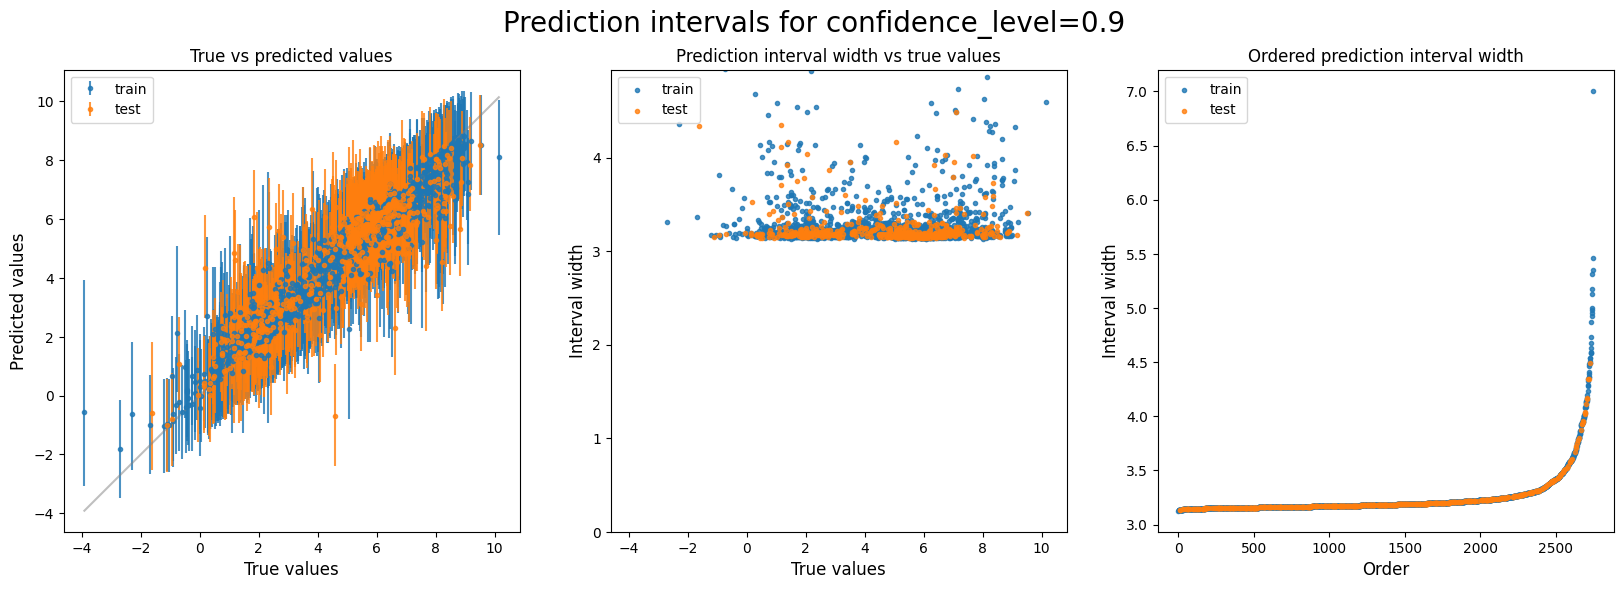

In [34]:
alpha_plot = int(np.where((confidence_level > 0.89) & (confidence_level < 0.91))[0])
plot_predictionintervals(
    y_train,
    y_train_pred,
    y_train_pis[:, 0, alpha_plot],
    y_train_pis[:, 1, alpha_plot],
    y_test,
    y_test_pred,
    y_test_pis[:, 0, alpha_plot],
    y_test_pis[:, 1, alpha_plot],
    "Prediction intervals for confidence_level=0.9",
)

## 5. Comparison of the uncertainty quantification methods

In the last section, we compare the calibration of several uncertainty-quantification methods provided by MAPIE using Random Forest as base model. To this aim, we build so-called "calibration plots" which compare the effective marginal coverage obtained on the test set with the target $1-\alpha$ coverage.

In [38]:
Params = TypedDict("Params", {"method": str, "cv": Union[int, Subsample]})
STRATEGIES = {
    "cv": {
        "class": CrossConformalRegressor,
        "init_params": dict(method="base", cv=5),
    },
    "cv_plus": {
        "class": CrossConformalRegressor,
        "init_params": dict(method="plus", cv=5),
    },
    "cv_minmax": {
        "class": CrossConformalRegressor,
        "init_params": dict(method="minmax", cv=5),
    },
    "jackknife_plus_ab": {
        "class": JackknifeAfterBootstrapRegressor,
        "init_params": dict(method="plus", resampling=20),
    },
}
mdl = get_regressor("random_forest")

In [39]:
y_pred, y_pis, scores = {}, {}, {}
RANDOM_STATE = 1
for strategy_name, strategy_params in STRATEGIES.items():
    init_params = strategy_params["init_params"]
    class_ = strategy_params["class"]
    mapie = class_(
        mdl, confidence_level=confidence_level,
        random_state=RANDOM_STATE, **init_params
    )
    mapie.fit_conformalize(X_train, y_train)
    y_pred[strategy_name], y_pis[strategy_name] = mapie.predict_interval(X_test)
    scores[strategy_name] = [
        regression_coverage_score(y_test, y_pis[strategy_name][:, 0, i], y_pis[strategy_name][:, 1, i])
        for i, _ in enumerate(confidence_level)
    ]

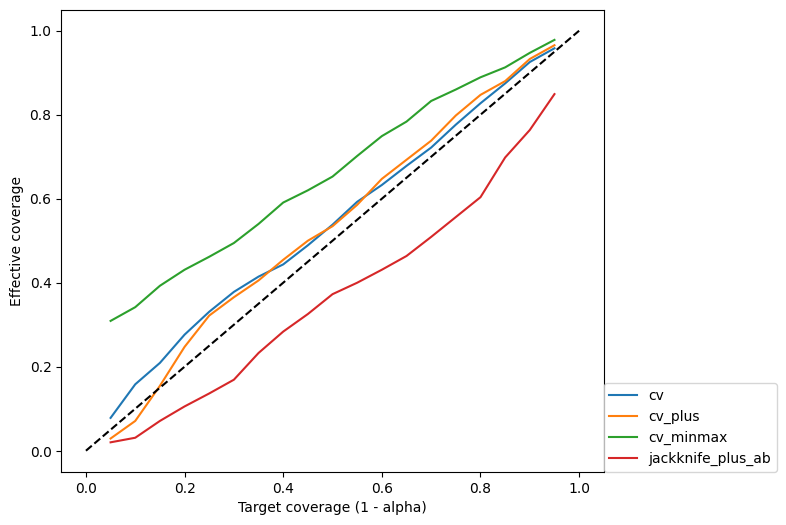

In [40]:
plt.figure(figsize=(7, 6))
plt.xlabel("Target coverage (1 - alpha)")
plt.ylabel("Effective coverage")
for strategy, params in STRATEGIES.items():
    plt.plot(confidence_level, scores[strategy], label=strategy)
plt.plot([0, 1], [0, 1], ls="--", color="k")
plt.legend(loc=[1, 0])

The calibration plot clearly demonstrates that the "naive" method underestimates the coverage by giving too narrow prediction intervals, due to the fact that they are built from training data. All other methods show much more robust calibration plots : the effective coverages follow almost linearly the expected coverage levels.